In [ ]:
from dataclasses import dataclass
from typing import Any
import math
import random
import copy
import numpy as np
import torch
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt

import src.game.game
import src.game.state
from src.game.game import Game
from src.game.state import GameState, GameStateTorch

import importlib
importlib.reload(src.game.game)
importlib.reload(src.game.state)
# Game = src.game.game.Game
# GameState = src.game.state.GameState
# GameStateTorch = src.game.state.GameStateTorch

In [252]:
class RandomAgent:
    def __init__(self):
        pass

    def play(self, state: GameState) -> np.ndarray:
        return np.ones((8, 8), dtype=np.float32) / 64.0

class SimpleCleverAgent:
    def __init__(self):
        pass

    def play(self, state: GameState) -> np.ndarray:
        hmm = state.mask_legal_moves() * state.oppq_board
        if hmm.sum() > 0.001:
            return hmm
        return np.ones((8, 8), dtype=np.float32) / 64.0

class SmolQAgent(nn.Module):
    def __init__(self, epsilon: float = 0.1):
        super().__init__()
        self.epsilon = epsilon
        self.proj = nn.Linear(4, 64)
        self.attn1 = nn.MultiheadAttention(64, 8, batch_first=True)
        self.ffn1 = nn.Sequential(
            nn.LayerNorm(64),
            nn.Linear(64, 256),
            nn.GELU(),
            nn.Linear(256, 64)
        )
        self.attn2 = nn.MultiheadAttention(64, 8, batch_first=True)
        self.ffn2 = nn.Sequential(
            nn.LayerNorm(64),
            nn.Linear(64, 256),
            nn.GELU(),
            nn.Linear(256, 64)
        )
        self.out = nn.Linear(64, 1)
        self.head_value = nn.Linear(64, 1)
        self.head_advantage = nn.Linear(64, 64)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        def core(x):
            B = x.size(0)
            x = x.permute(0, 2, 3, 1).reshape(B, 64, 4)
            x = self.proj(x)
            attn1_out = self.attn1(x, x, x)[0]
            x = x + attn1_out
            x = x + self.ffn1(x)
            attn2_out = self.attn2(x, x, x)[0]
            x = x + attn2_out
            x = x + self.ffn2(x)
            x = self.out(x)
            x = x.reshape(B, 64)
            v = self.head_value(x)
            a = self.head_advantage(x)
            x = v + a - a.mean(dim=1, keepdim=True)
            return x.view(B, 8, 8)
        x = core(x)
        return x.view(-1, 64)

    def play(self, state: GameState) -> np.ndarray:
        state_torch = state.convert_to_torch()
        with torch.no_grad():
            if torch.randn(1) < self.epsilon:
                best_action_probs = torch.ones((8, 8), dtype=torch.float32) / 64
            else:
                res = self(state_torch.all_boards().unsqueeze(0)).squeeze(0)
                illegal_mask = 1 - state_torch.legal_moves_mask.flatten()
                res = res - illegal_mask * 100
                best_ind = torch.argmax(res)
                best_action_probs = torch.full_like(res, 0.0)
                best_action_probs.scatter_(0, best_ind.unsqueeze(0), 1.0)
        return best_action_probs.view(8,8).cpu().numpy()


In [ ]:
@dataclass
class ReplayEntry:
    state: GameStateTorch
    action: torch.Tensor
    reward: float
    next_state: GameStateTorch
    done: bool

In [254]:
def empty_game_state_torch() -> GameStateTorch:
    return GameStateTorch(
        blockers_board=torch.zeros((8, 8), dtype=torch.float32),
        selfq_board=torch.zeros((8, 8), dtype=torch.float32),
        oppq_board=torch.zeros((8, 8), dtype=torch.float32),
        legal_moves_mask=torch.ones((8, 8), dtype=torch.float32)
    )

In [255]:
def get_reward(game: Game, side: bool, legal: bool) -> float:
    reward = 0
    if game.result is not None:
        reward = 1 if game.result == side else -1
    reward -= 0.005 if not legal else 0
    reward += float(game.heuristic_reward())
    return reward * 10

In [293]:
def train_step(agent: nn.Module, target: nn.Module, optimizer: torch.optim.Optimizer, buffer: list[ReplayEntry], GAMMA: float = 0.99) -> float:
    optimizer.zero_grad()
    device = buffer[0].state.selfq_board.device

    states = torch.stack([entry.state.all_boards() for entry in buffer]).to(device)
    actions = torch.stack([entry.action for entry in buffer]).to(device)
    rewards = torch.as_tensor([entry.reward for entry in buffer], dtype=torch.float32, device=device)
    next_states = torch.stack([entry.next_state.all_boards() for entry in buffer]).to(device)
    dones = torch.as_tensor([entry.done for entry in buffer], dtype=torch.float32, device=device)

    q_values = agent(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
        best_actions = agent(next_states).argmax(1, keepdim=True)
        next_q_values = target(next_states).gather(1, best_actions).squeeze(1)
    target_q_values = rewards + (1 - dones) * next_q_values * GAMMA

    assert q_values.shape == target_q_values.shape, f"q_values shape {q_values.shape} does not match target_q_values shape {target_q_values.shape}"
    loss = nn.functional.mse_loss(q_values, target_q_values)
    loss.backward()
    optimizer.step()

    return loss.item()

In [294]:
def soft_update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            tau * source_param.data + (1.0 - tau) * target_param.data
        )

In [287]:
agent = SmolQAgent()
target = copy.deepcopy(agent)
def oppo_choose():
    ghh.epsilon = 0
    return random.choice([SimpleCleverAgent(), ghh])
optimizer = torch.optim.Adam(agent.parameters(), lr=1.5e-3, betas=(0.9, 0.999))
epoch = 0

In [288]:
buffer: list[ReplayEntry] = []
ENTRIES_PER_TRAIN_STEP = 512
UPDATES_PER_TRAIN_STEP = 12
win_rate_graph = []
reward_graph = []
legal_graph = []
is_white_agent = True

In [289]:
agent.epsilon = 0.1
while True:
# for _ in range(1):
    print(f"Epoch {epoch}")
    agent.eval()
    game = Game(agent, oppo_choose()) if is_white_agent else Game(oppo_choose(), agent)
    reward_list = []
    legal_list = []
    win_list = []
    for _ in range(ENTRIES_PER_TRAIN_STEP * 2):
        if game.result is not None:
            game.white = agent if is_white_agent else oppo_choose()
            game.black = oppo_choose() if is_white_agent else agent
            game.reset()
        if game.is_white_turn != is_white_agent:
            game.agent_move()
            reward = get_reward(game, is_white_agent, True)
            if game.result is not None:
                win_list.append(game.result == is_white_agent)
                is_white_agent = not is_white_agent
            buffer[-1].reward += reward
            reward_list.append(buffer[-1].reward)
            continue
        state = game.get_state().convert_to_torch()
        _, move, legal = game.agent_move()
        reward = get_reward(game, is_white_agent, legal)
        legal_list.append(legal)
        if game.result is not None:
            win_list.append(game.result == is_white_agent)
            is_white_agent = not is_white_agent
        done = game.result is not None
        next_state = game.get_state().convert_to_torch() if not done else empty_game_state_torch()
        entry = ReplayEntry(
            state=state,
            action=torch.tensor(move, dtype=torch.int64, device=state.selfq_board.device),
            reward=reward,
            next_state=next_state,
            done=done,
        )
        buffer.append(entry)
    reward_graph.append(np.mean(reward_list))
    legal_graph.append(len(list(x for x in legal_list if x)) / len(legal_list))
    win_rate_graph.append(len(list(x for x in win_list if x)) / len(win_list))
    print(f"Average reward: {np.mean(reward_list):.4f}, unnoised: {np.mean(reward_graph[-20:])}")
    print(f"Chance of legal move: {len(list(x for x in legal_list if x)) / len(legal_list):.2%}, unnoised: {np.mean(legal_graph[-20:]):.2%}")
    print(f"Win rate: {len(list(x for x in win_list if x)) / len(win_list):.2%}, unnoised: {np.mean(win_rate_graph[-20:]):.2%}")
    print(f"Games played this epoch: {len(win_list)}")
    print("Switching to training mode")

    agent.train()
    loss_list = []
    for i in range(UPDATES_PER_TRAIN_STEP):
        sample_buffer = random.sample(buffer, 96)
        loss = train_step(agent, target, optimizer, sample_buffer)
        loss_list.append(loss)
    print(f"Loss: mean={np.mean(loss_list):.4f}, median={np.median(loss_list):.4f}, std={np.std(loss_list):.4f}")
    random.shuffle(buffer)
    del buffer[:int(len(buffer) * 0.02)]
    soft_update(target, agent, tau=0.015)
    epoch += 1
    print("Switching to playing mode")
    print()


Epoch 0
Average reward: -1.7728, unnoised: -1.7727678571428571
Chance of legal move: 100.00%, unnoised: 100.00%
Win rate: 16.46%, unnoised: 16.46%
Games played this epoch: 79
Switching to training mode
Loss: mean=14.8693, median=14.5480, std=3.3664
Switching to playing mode

Epoch 1
Average reward: -1.7817, unnoised: -1.7772094395029874
Chance of legal move: 100.00%, unnoised: 100.00%
Win rate: 16.25%, unnoised: 16.35%
Games played this epoch: 80
Switching to training mode
Loss: mean=14.8812, median=14.5105, std=3.2189
Switching to playing mode

Epoch 2
Average reward: -1.6957, unnoised: -1.7500344676051662
Chance of legal move: 100.00%, unnoised: 100.00%
Win rate: 14.08%, unnoised: 15.60%
Games played this epoch: 71
Switching to training mode
Loss: mean=14.1228, median=13.9901, std=1.6324
Switching to playing mode

Epoch 3
Average reward: -1.7415, unnoised: -1.7478975408279205
Chance of legal move: 100.00%, unnoised: 100.00%
Win rate: 17.11%, unnoised: 15.97%
Games played this epoch: 

KeyboardInterrupt: 

In [167]:
sum([x.reward for x in buffer]) / len(buffer)

-2.0916299662668667

In [14]:
# base win rate
game = Game(RandomAgent(), SimpleCleverAgent())
wins = 0
for _ in range(10000):
    game.reset()
    while game.result is None:
        game.agent_move()
    wins += 1 if game.result else 0
print(f"Base win rate: {wins / 10000:.2%}")

Base win rate: 5.64%


In [292]:
agent.eval()
agent.epsilon = 0
game = Game(agent, ghh)
wins = 0
for _ in range(300):
    game.reset()
    while game.result is None:
        game.agent_move()
    wins += 1 if game.result else 0
print(f"Win rate: {wins / 300:.2%}")

Win rate: 27.00%


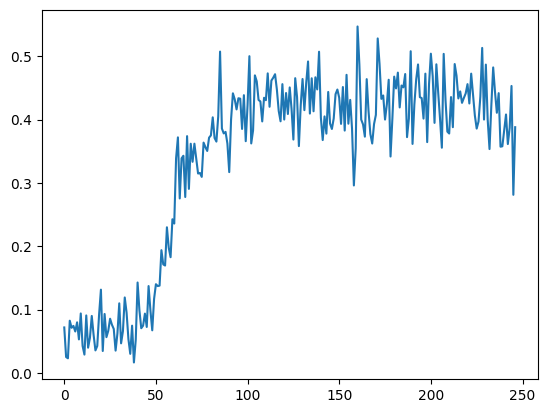

In [180]:
plt.plot(win_rate_graph)
plt.show()

In [37]:
graph_np = np.array(reward_graph)
autocorr = np.corrcoef(graph_np[:-1], graph_np[1:])[0, 1]
print(f"Autocorrelation: {autocorr:.4f}")

Autocorrelation: 0.1476


In [ ]:
def profiled():
    game = Game(oppo, oppo)
    wins = 0
    for _ in range(200):
        game.reset()
        while game.result is None:
            game.agent_move()
        wins += 1 if game.result else 0

%prun -s cumulative -l 10 profiled()

In [245]:
# visual debug test
agent.train()
# agent.eval()
game = Game(agent, oppo_choose())
game.reset()
while game.result is None:
    print(game.repr_board())
    print()
    game.agent_move()
print(game.repr_board())
print(f"result {game.result}")

. . . . W . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . B . . . .

. . . . █ . W .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . B . . . .

. . . . █ . W .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . B . . .
. . . █ . . . .

. . . . █ . █ .
. . . . . . . .
. . . . . . . .
. . . W . . . .
. . . . . . . .
. . . . . . . .
. . . . B . . .
. . . █ . . . .

. . . . █ . █ .
. . . . . . . .
B . . . . . . .
. . . W . . . .
. . . . . . . .
. . . . . . . .
. . . . █ . . .
. . . █ . . . .

. . . . █ . █ .
. . . . . W . .
B . . . . . . .
. . . █ . . . .
. . . . . . . .
. . . . . . . .
. . . . █ . . .
. . . █ . . . .

. . . . █ . █ .
. . . . . W . .
█ . . . . . . .
. . . █ . . . .
. . . . . . . .
. . . B . . . .
. . . . █ . . .
. . . █ . . . .

. . . . █ . █ .
. . . . . █ . .
█ . . . . W . .
. . . █ . . . .
. . . . . . . .
. . . B . . . .
.

In [ ]:
len(list(x for x in win_rate_graph if x > 0.5)) / len(win_rate_graph)

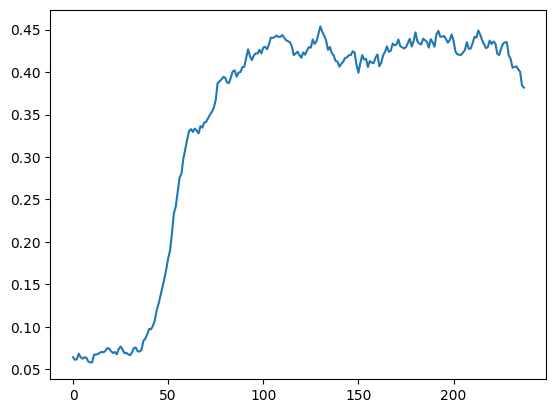

In [181]:
window = 10
smoothed = np.convolve(win_rate_graph, np.ones(window)/window, mode='valid')
plt.plot(smoothed)
plt.show()

. . . █ █ . . .
. . . W . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. █ B . . . . .
. . . . . . . .
. . . █ . . . .


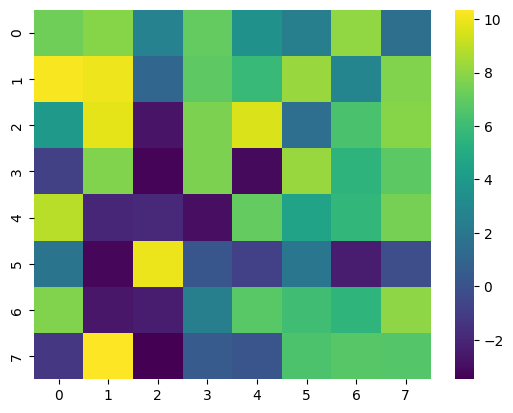

In [250]:
game = Game(RandomAgent(), RandomAgent())
game.reset()
for _ in range(4):
    game.agent_move()
    if game.result is not None:
        break
# agent.head_advantage(agent.conv(game.get_state().convert_to_torch().all_boards().unsqueeze(0))).squeeze(0).reshape((8, 8))
# agent.head_value(agent.conv(game.get_state().convert_to_torch().all_boards().unsqueeze(0))).squeeze(0)
# agent.eval()
agent.train()
if game.result is None:
    data = agent(game.get_state().convert_to_torch().all_boards().unsqueeze(0))
    print(game.repr_board())
    sns.heatmap(data.view(8,8).detach().numpy(), cmap="viridis")

In [ ]:
game.get_state().convert_to_torch().all_boards()

In [263]:
def core(x, self):
    x = self.conv(x)
    x = self.trunk(x)
    v = self.head_value(x)
    a = self.head_advantage(x)
    x = v + a - a.mean(dim=1, keepdim=True)
    return x.view(-1, 8, 8)

In [210]:
torch.save(agent.state_dict(), "models/first_attention/first_attention.pth")

In [222]:
agenteeee = copy.deepcopy(agent)

In [281]:
ghh_dict = torch.load("models/works_somehow/works_somehow.pth")
ghh = SmolQAgent()
ghh.load_state_dict(ghh_dict)

<All keys matched successfully>

In [280]:
torch.save(agenteeee.state_dict(), "models/works_somehow/works_somehow.pth")